**Análise de Custo de Plano de Saúde com Árvores de Decisão**

Este notebook apresenta a criação de um modelo de Decision Tree para prever os custos de planos de saúde de pacientes com base em características pessoais.
O conjunto de dados utilizado contém informações demográficas e relacionadas à saúde, incluindo idade, sexo, índice de massa corporal (IMC), número de filhos,
se o paciente é fumante, região geográfica, entre outras. O objetivo do modelo é fornecer estimativas dos custos médicos anuais para auxiliar em políticas de precificação de seguros de saúde.
O dataset contém dados de pacientes adultos dos Estados Unidos e foi retirado do Kaggle: https://www.kaggle.com/datasets/teertha/ushealthinsurancedataset


### Carregamento de Dados
Neste passo, carregamos o conjunto de dados e visualizamos as primeiras informações, verificando sua estrutura e características principais.


In [39]:
import pandas as pd
df = pd.read_csv("data/us-insurance-data.csv", sep=",")


### Visualizando o Conjunto de Dados

Exibimos as primeiras linhas do dataset para explorar suas variáveis e entender os dados que serão utilizados no modelo.


In [40]:
display(df.head())


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Exibindo Informações e Tipos de Dados

Exibimos as informações gerais do dataset, incluindo os tipos de dados em cada coluna, para verificar a estrutura e identificar possíveis ajustes.


In [41]:
display(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


None

### Resumo Estatístico dos Dados Numéricos

Apresentamos o resumo estatístico para as variáveis numéricas, analisando média, mediana, quartis e outras métricas relevantes para entender a distribuição dos dados.


In [42]:
display(df.describe())


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


### Tratamento de Valores Ausentes

Para garantir a integridade do dataset, realizamos o tratamento de valores ausentes. 
Substituímos valores ausentes nas colunas numéricas pela **mediana** e removemos registros com valores ausentes nas colunas categóricas e na coluna `charges` (alvo de previsão),
pois esses não podem ser substituídos de maneira adequada.


In [43]:
display(df.isnull().sum())
from sklearn.impute import SimpleImputer

numerical_cols = ['age', 'bmi', 'children']
numerical_imputer = SimpleImputer(strategy='median')
df[numerical_cols] = numerical_imputer.fit_transform(df[numerical_cols])


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### Pré-processamento: Transformação das Variáveis

Aplicamos a padronização em variáveis numéricas e a codificação One-Hot nas variáveis categóricas.
Esse pré-processamento melhora a eficiência do modelo ao lidar com variáveis de diferentes escalas e categorias.


In [44]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

categorical_cols = ['sex', 'smoker', 'region']
numerical_cols = ['age', 'bmi', 'children']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])


### Distribuição da Variável Alvo (`charges`)

Através de um histograma, analisamos a distribuição dos custos (`charges`), identificando a frequência de diferentes faixas de custos e a presença de valores atípicos.


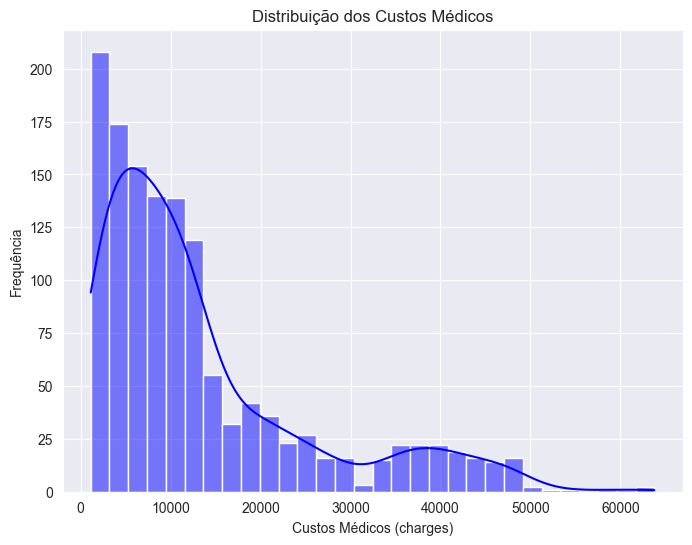

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.histplot(df['charges'], kde=True, color='blue')
plt.title('Distribuição dos Custos Médicos')
plt.xlabel('Custos Médicos (charges)')
plt.ylabel('Frequência')
plt.show()


### Mapa de Correlação entre as Variáveis

Geramos um heatmap para identificar a correlação entre as variáveis do dataset e o alvo `charges`.
Entender essas correlações é essencial para identificar variáveis relevantes para o modelo.


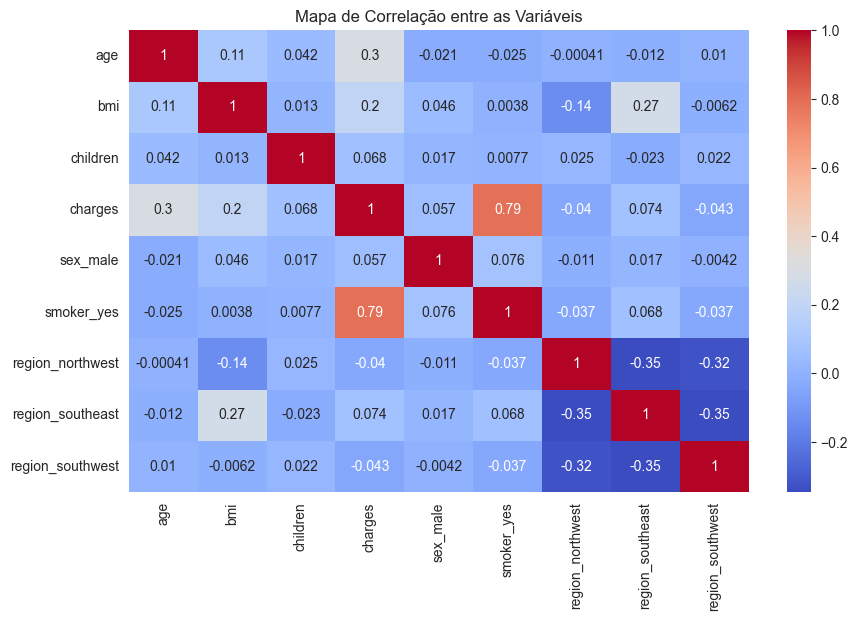

In [46]:
df_encoded = pd.get_dummies(df, drop_first=True)

plt.figure(figsize=(10,6))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm')
plt.title('Mapa de Correlação entre as Variáveis')
plt.show()


### Pré-processamento e Substituição das Colunas no DataFrame

Aplicamos o pré-processamento ao conjunto de dados e organizamos o DataFrame final com as variáveis ajustadas para o modelo.


In [47]:
import numpy as np

x = df.drop('charges', axis=1)
y = df['charges']
x_preprocessed = preprocessor.fit_transform(x)

num_features = numerical_cols
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = np.concatenate([num_features, cat_features])

# Criando o DataFrame com as features pré-processadas
X_preprocessed_df = pd.DataFrame(x_preprocessed, columns=feature_names)
X_preprocessed_df.reset_index(drop=True, inplace=True)
y = y.reset_index(drop=True)


### Separação dos Dados em Treino e Teste

Dividimos o dataset em conjuntos de treino e teste, com 80% dos dados para o treinamento do modelo e 20% para avaliação.
Essa divisão permite avaliar a capacidade de generalização do modelo em dados novos.


In [48]:
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed_df, y, test_size=0.30, random_state=42)


### Construção do Modelo de Decision Tree

Neste passo, criamos e treinamos um modelo de Decision Tree para prever os custos médicos. 
Ajustamos a profundidade máxima (`max_depth=5`) após testes preliminares para otimizar a precisão.


In [49]:
from sklearn.tree import DecisionTreeRegressor

dt_regressor = DecisionTreeRegressor(random_state=42, criterion='squared_error', max_depth=5)
dt_regressor.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=5, random_state=42)

### Avaliação do Modelo com R² Score

Avaliamos o desempenho do modelo no conjunto de teste usando o coeficiente de determinação (R²), que mede o quão bem as previsões se ajustam aos dados reais.


In [50]:
from sklearn.metrics import r2_score

y_pred = dt_regressor.predict(X_test)
r_squared = r2_score(y_test, y_pred)

print("Score no Treino: ", dt_regressor.score(X_train, y_train))
print("Score no Teste: ", dt_regressor.score(X_test, y_test))
print('\nR2 Score:', r_squared)


Score no Treino:  0.8770784786017006
Score no Teste:  0.8555497993103209

R2 Score: 0.8555497993103209


### Comparação entre Valores Reais e Preditos

O gráfico abaixo mostra a relação entre os valores reais e preditos pelo modelo.
A linha vermelha representa o ideal, onde as previsões coincidem com os valores reais.


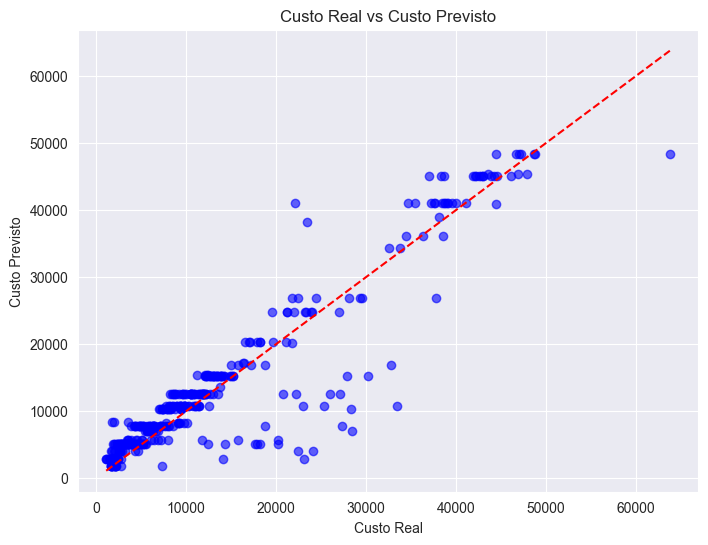

In [51]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Custo Real')
plt.ylabel('Custo Previsto')
plt.title('Custo Real vs Custo Previsto')
plt.show()


### Visualização da Decision Tree

Apresentamos a estrutura da árvore de decisão para interpretar as decisões do modelo e verificar quais variáveis tiveram maior influência nas previsões.


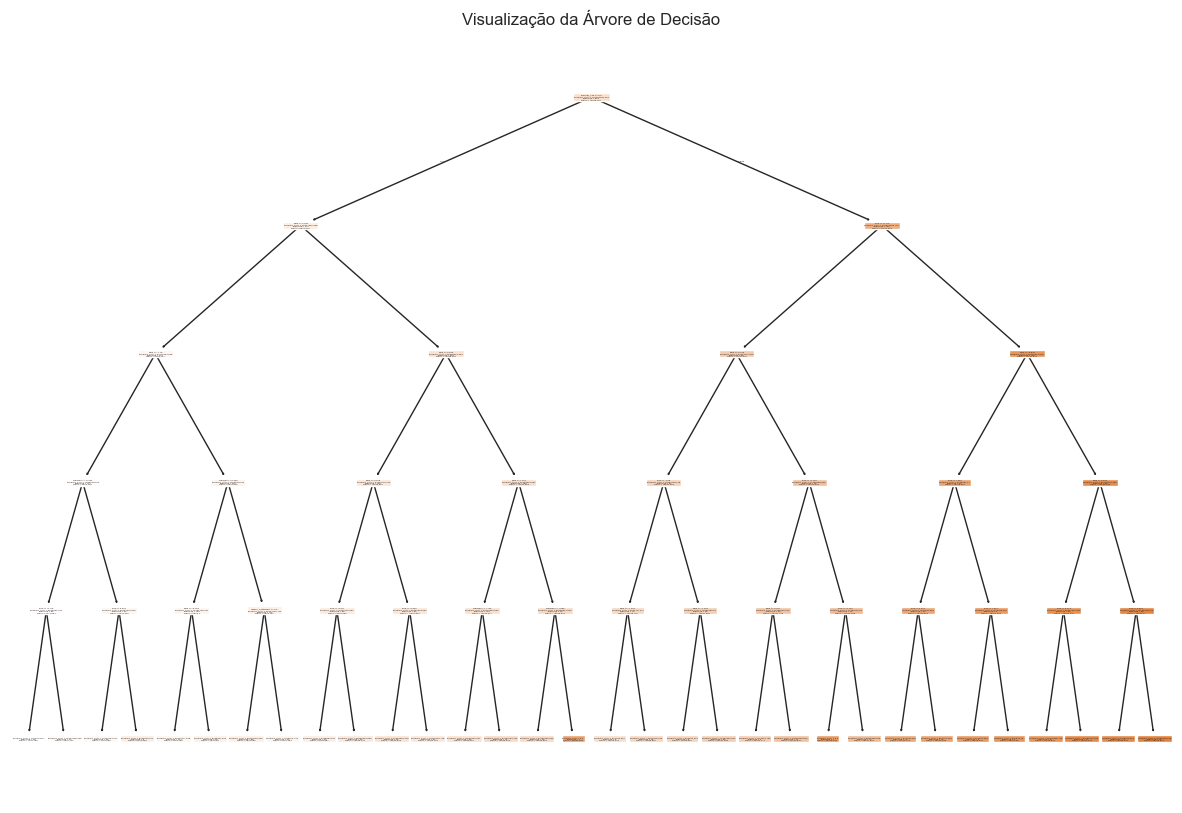

In [52]:
import matplotlib.pyplot as plt
from sklearn import tree

plt.figure(figsize=(15, 10))
tree.plot_tree(
    dt_regressor,
    feature_names=feature_names,
    class_names=['Low', 'High'],
    filled=True
)
plt.title('Visualização da Árvore de Decisão')
plt.show()


## Implementação do Random Forest Regressor

Aqui, implementamos um modelo Random Forest como comparação adicional.
Realizamos testes preliminares e determinamos que `n_estimators=6` e `max_depth=6` são parâmetros ideais para o modelo.


In [53]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=6, max_depth=6, random_state=7)


### Treinamento do Modelo Random Forest

Treinamos o modelo Random Forest no conjunto de treino e o avaliamos posteriormente.


In [54]:
rf.fit(X_train, y_train) 
y_predito_random_forest = rf.predict(X_test) 


### Avaliação do Modelo Random Forest

Avaliamos o desempenho do modelo Random Forest usando o R² Score para comparar com o modelo de Decision Tree.


In [55]:
print("Score no Treino: ", rf.score(X_train, y_train))
print("Score no Teste: ", rf.score(X_test, y_test))
r_squared_rf = r2_score(y_test, y_predito_random_forest)
print('\nR2 Score para Random Forest:', r_squared_rf)


Score no Treino:  0.902766793070781
Score no Teste:  0.8635437751481823

R2 Score para Random Forest: 0.8635437751481823


### Comparação entre Valores Reais e Preditos para Random Forest

O gráfico abaixo mostra a relação entre os valores reais e os preditos pelo modelo Random Forest, similar ao gráfico da árvore de decisão.


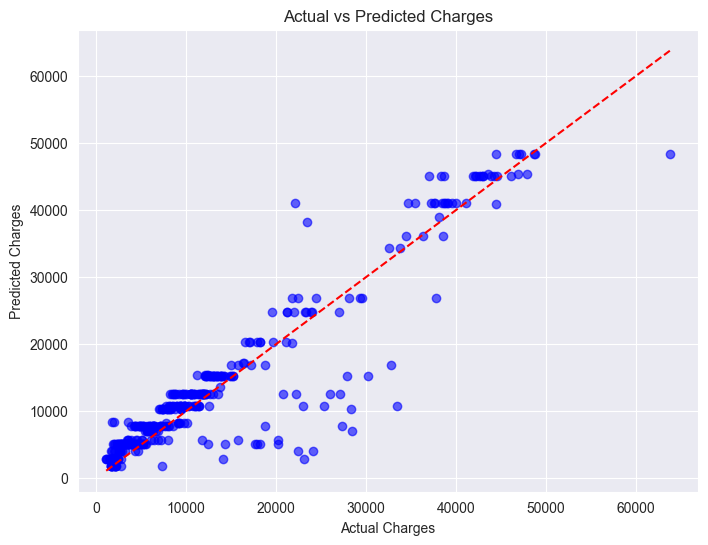

In [56]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs Predicted Charges')
plt.show()

### Visualização da Decision Tree

Apresentamos a estrutura da árvore de decisão para interpretar as decisões do modelo e verificar quais variáveis tiveram maior influência nas previsões.

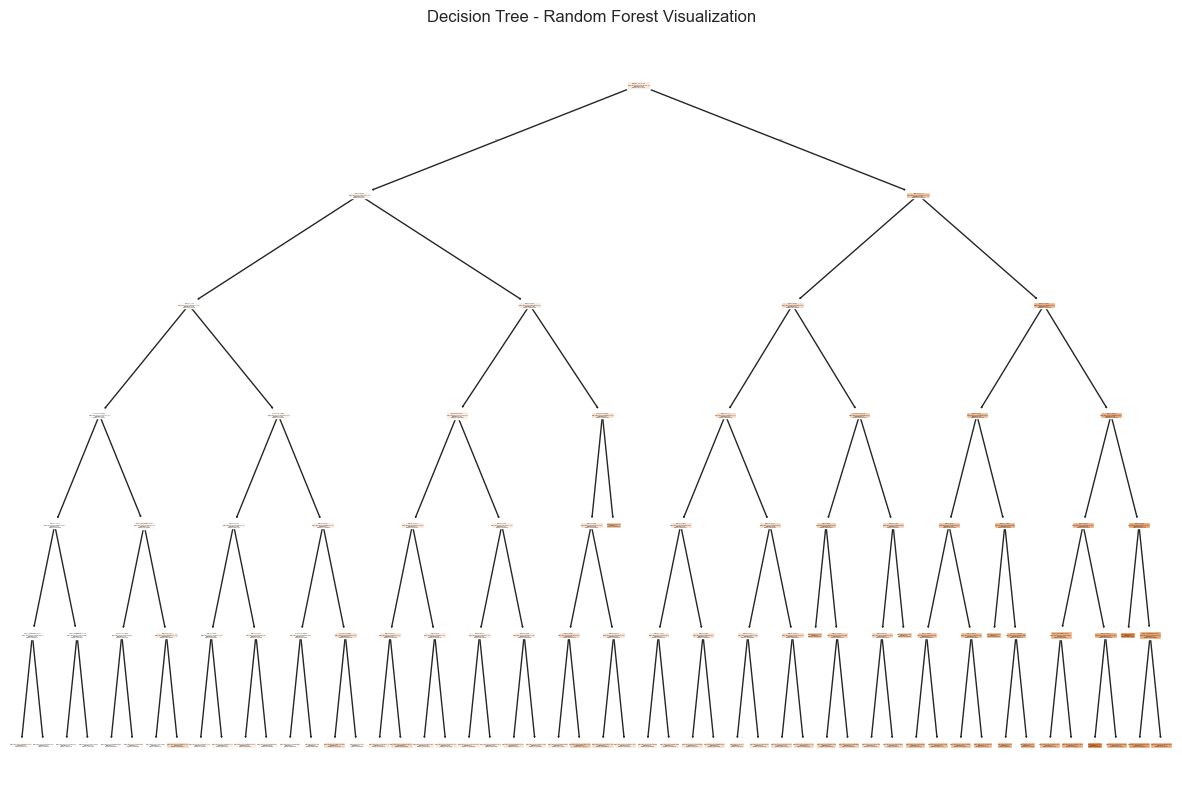

In [57]:
plt.figure(figsize=(15, 10))
tree.plot_tree(
    rf.estimators_[0],
    feature_names=feature_names,
    class_names=['Low', 'High'],
    filled=True
)
plt.title('Decision Tree - Random Forest Visualization')
plt.show()